# Data Import & Preprocessing 
### Project: Exploring Trends in US Happiness with Census Data
Team Members: Taylor Witte, Donald Yu, Praveen Manimaran, Vitush Agarwal, Parker Aman
UCSD Spring 2024 232R Big Data Analytics Using Spark 


## Enviroment Setup

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import logging
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from pyspark.sql.functions import explode
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row
from pyspark.sql.functions import sum as spark_sum

## Import Datasets

In [3]:
# Import necessary modules
from pyspark.sql import SparkSession

# Create a SparkSession object
spark = SparkSession.builder \
    .appName("BigDataGroupProject") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/09 10:33:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#World Happiness Data
world_happiness = pd.read_csv('World Happiness Report.csv')

# Filter for USA & years of cencus data
US_happiness =  world_happiness.loc[world_happiness['Country Name'] == 'United States']
US_happiness = US_happiness[US_happiness.Year >= 2012]
US_happiness = US_happiness[US_happiness.Year != 2020]

In [29]:
#Import Individual Census Data 

# Define the path to the CSV file
file_path = "usa_00006.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_id = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
df_id.printSchema()

# Show the first few rows of the DataFrame
df_id.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- PERNUM: integer (nullable = true)
 |-- CBPERNUM: integer (nullable = true)
 |-- PERWT: double (nullable = true)
 |-- FAMSIZE: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- MARST: integer (nullable = true)
 |-- RACE: integer (nullable = true)
 |-- RACED: integer (nullable = true)
 |-- CITIZEN: integer (nullable = true)
 |-- HCOVANY: integer (nullable = true)
 |-- SCHOOL: integer (nullable = true)
 |-- EDUC: integer (nullable = true)
 |-- EDUCD: integer (nullable = true)
 |-- SCHLTYPE: integer (nullable = true)
 |-- EMPSTAT: integer (nullable = true)
 |-- EMPSTATD: integer (nullable = true)


In [5]:
#Import Household Census Data 

# Define the path to the CSV file
file_path = "usa_00007.csv" #change this to your own!!

# Read the CSV file into a DataFrame
df_hh = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the schema of the DataFrame
df_hh.printSchema()

# Show the first few rows of the DataFrame
df_hh.show(5)

root
 |-- YEAR: integer (nullable = true)
 |-- SAMPLE: integer (nullable = true)
 |-- SERIAL: integer (nullable = true)
 |-- CBSERIAL: long (nullable = true)
 |-- HHWT: double (nullable = true)
 |-- HHTYPE: integer (nullable = true)
 |-- CLUSTER: long (nullable = true)
 |-- CPI99: double (nullable = true)
 |-- STATEICP: integer (nullable = true)
 |-- MET2023: integer (nullable = true)
 |-- STRATA: integer (nullable = true)
 |-- GQ: integer (nullable = true)
 |-- FARM: integer (nullable = true)
 |-- OWNERSHP: integer (nullable = true)
 |-- OWNERSHPD: integer (nullable = true)
 |-- TAXINCL: integer (nullable = true)
 |-- INSINCL: integer (nullable = true)
 |-- RENTGRS: integer (nullable = true)
 |-- CONDOFEE: integer (nullable = true)
 |-- MOBLHOME: integer (nullable = true)
 |-- COSTELEC: integer (nullable = true)
 |-- COSTGAS: integer (nullable = true)
 |-- COSTWATR: integer (nullable = true)
 |-- COSTFUEL: integer (nullable = true)
 |-- HHINCOME: integer (nullable = true)
 |-- FOODSTM

## Explore World Happiness Database 

In [5]:
#Visualize US Happiness Dataset 
US_happiness.head()

,Country Name,Regional Indicator,Year,Life Ladder,Log GDP Per Capita,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Perceptions Of Corruption,Positive Affect,Negative Affect,Confidence In National Government
2077,United States,North America and ANZ,2012,7.026227,10.929592,0.903192,66.660004,0.822662,0.210162,0.710034,0.764520,0.259644,0.348856
2078,United States,North America and ANZ,2013,7.249285,10.940915,0.925397,66.639999,0.792256,0.269373,0.746894,0.776116,0.260328,0.288648
2079,United States,North America and ANZ,2014,7.151114,10.956202,0.902097,66.620003,0.866077,0.216904,0.702267,0.785791,0.281265,0.348671
2080,United States,North America and ANZ,2015,6.863947,10.975543,0.903571,66.599998,0.848753,0.215132,0.697543,0.768671,0.274688,0.346936
2081,United States,North America and ANZ,2016,6.803600,10.984834,0.896751,66.474998,0.757893,0.139648,0.738920,0.736574,0.264204,0.297206


In [10]:
#Exploring Happiness Data

#Get Variables
hap_var = list(US_happiness.columns)
print("Number of Variables:", len(hap_var))
print("Variables:", hap_var)

#Number of Years
print( "Years Represented by Data:" ,US_happiness['Year'].unique())

Number of Variables: 13
Variables: ['Country Name', 'Regional Indicator', 'Year', 'Life Ladder', 'Log GDP Per Capita', 'Social Support', 'Healthy Life Expectancy At Birth', 'Freedom To Make Life Choices', 'Generosity', 'Perceptions Of Corruption', 'Positive Affect', 'Negative Affect', 'Confidence In National Government']
Years Represented by Data: [2012 2013 2014 2015 2016 2017 2018 2019 2021 2022]


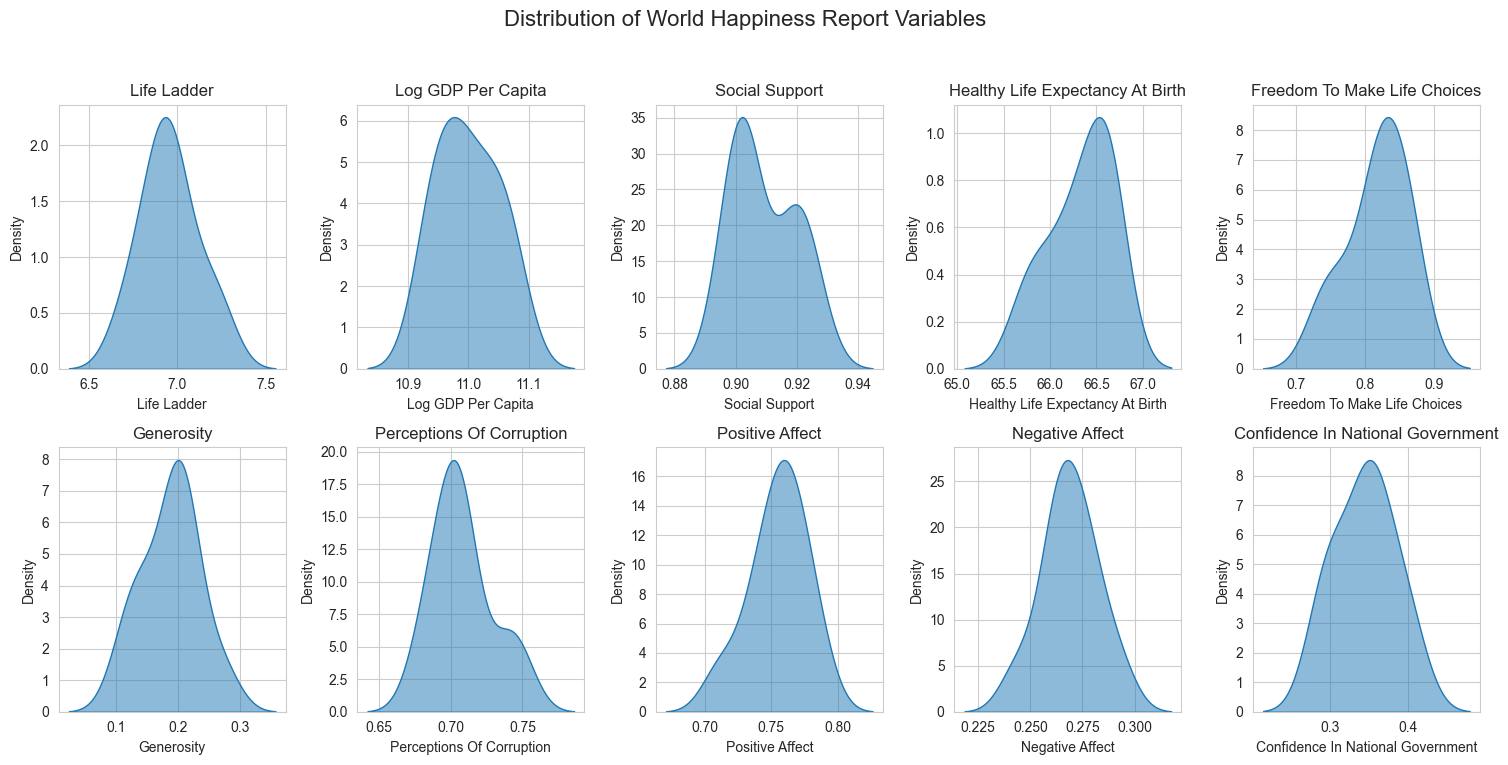

In [11]:
#Plot Distrubution of Happiness Variables

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each subplot
for i in range(10):
    ax = axes[i]
    j = i + 3
    sns.kdeplot(data=US_happiness, x=hap_var[j], fill=True, palette="crest", alpha=.5, ax=ax)
    ax.set_title(f"{hap_var[j]}")  # Adding title to each subplot

fig.suptitle("Distribution of World Happiness Report Variables", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

All of the variables in the World Happiness Report appears to be normally distributed across the years included in this dataset measured in the US.

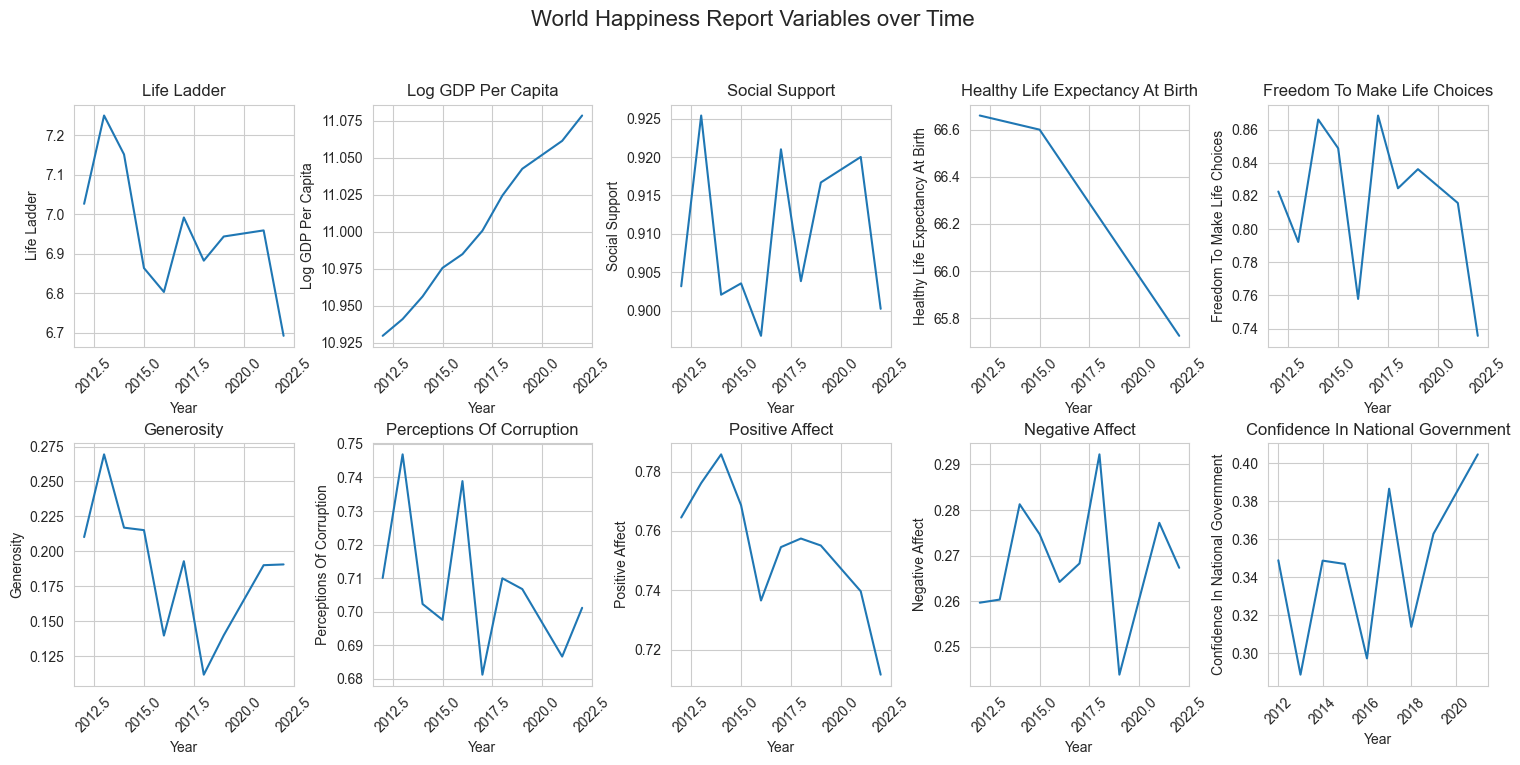

In [12]:
#Plot Variables of Time

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

# Loop through each subplot
for i in range(10):
    ax = axes[i]
    j = i + 3
    sns.lineplot(data=US_happiness, x="Year", y=hap_var[j], ax=ax)
    ax.set_title(f"{hap_var[j]}")
    ax.set_xlabel("Year")
    ax.set_ylabel(hap_var[j])
    ax.tick_params(axis='x', rotation=45)

fig.suptitle("World Happiness Report Variables over Time", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Description & Stability of Variables over time 


*   **Life Ladder**: (also referred to as Cantril life ladder). Life ladder is the national average reponse the Gallup World poll which is stated as  *“Please imagine a ladder, with steps numbered from 0 at the bottom to 10 at the top. The top of the ladder represents the best possible life for you and the bottom of the ladder represents the worst possible life for you. On which step of the ladder would you say you personally feel you stand at this time?”* The national average response appears to be decreasing over time from 7 to 6. It is worth nothing the scale is smaller shown in the graph is quite small so the those fluctions are minor.  

*   **GDP per capita**: The GPD per captia is scaled logarithmically and normalized to a constant 2017 international dollar. The GPD per capita is increasing consistenly over time. Although the increase is quite small with a 0.14 difference on the log scale over 10 years that equates to 35 billion dollar increase.

*   **Social Support**: The Social support variables is the national average on a binary scale in response to the question *“If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?”* This score appears to be quite consisten over time with slightly fluctions with a range of 2.5%.


*   **Health Life Expectancy at Birth**: The life expectancy at birth is monitored the World Health Organization. The US life expectrancy at birth appears to be decreasing over time with an almost 1% decrease over 10 year which is a considerable amount of lives on the scale of the US population of over 300 million people.

*   **Freedom**: Freedom to make life choices is the national average of responses to the question *“Are you satisfied or dissatisfied with your freedom to choose what you do with your life?”*  This variable appears to flucate over the past ten years.

*   **Generosity**: Generosity is represented by the residual national average to the question “Have you donated money to a charity in the past month?” on GDP per capita. Generosity flucates over time but appears to have a downward trend over the ten year period.

*   **Percent of Corruption**: Percent of Corruption is represented by indivudals perception of corruption which is measured by the national average of two true or false questions:
1.   “Is corruption widespread throughout the government or not”
2.   “Is corruption widespread within businesses or not?”
Percent of corruption fluctuates between years but appears to possibly be in a downward trend over the ten year period.

*   **Positive Affect**: Postive affect represents the national average of three Gallup World Pole Questions:
1.   “Did you smile or laugh a lot yesterday?”
2.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Enjoyment?”
3.   “Did you learn or do something interesting yesterday?”
Positive affect appears to be decreasing over the ten year period.

*   **Negative Affect**: Negative Affect is also the national average of three Gallip World Pole Questions:
1.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Worry?”
2.   “Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Sadness?”
3.   Did you experience the following feelings during A LOT OF THE DAY yesterday? How about Anger?”
Although postive affect appears to be decreasing, negative effect appears to consistent with small flucations.

*   **National Government**: The National Goverment Variables is relative to the 75th percentile of the global distribution of the first princial componenet of five measurements of confidence in the national government, judicial syste, courts, and honesty of election, local police force, and percieved corruption in business. This measurement fluctates but appears to be on an upward trend.

## Explore Individual Census Data

In [44]:
##### Examine Null Counts 
null_counts = [df_id.where(col(column).isNull()).count() for column in df_id.columns]
null_counts_dict = dict(zip(df_id.columns, null_counts))
print("Number of null values in each column:")
print(null_counts_dict)

#Most Nulls are represented by 0 in categorical variables 

### Add code to count n/a or missing represented by a numerical key 

In [31]:
#Variables 
print("Number of Variables:",len(df_id.columns))
print("Number of Instances:", df_id.count())
print("Number of Households:", df_id.select("SERIAL").distinct().count())

Number of Variables: 31


Number of Instances: 10002255


Number of Households: 1416026


In [36]:
#Normalize Monitary Values to 2000 with CPI99
df_id = df_id.withColumn('AINCTOT', df_id.INCTOT * df_id.CPI99)
df_id = df_id.withColumn('AFTOTINC', df_id.FTOTINC * df_id.CPI99)
df_id = df_id.withColumn('AINCWELFR', df_id.INCWELFR * df_id.CPI99)
df_id = df_id.withColumn('AINCINVST', df_id.INCINVST * df_id.CPI99)
df_id = df_id.withColumn('APOVERTY', df_id.POVERTY * df_id.CPI99)
#Store raw monetary values
raw_id = df_id.select('SAMPLE', 'CBSERIAL', 'INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST', 'POVERTY')
#Remove raw monetary value from dataframe 
df_id = df_id.drop('INCTOT', 'FTOTINC', 'INCWELFR', 'INCINVST', 'POVERTY')

#### Individual Census Data Variables 

##### Technical Variables 
*   **Year**: Census year ranging from 
*   **SAMPLE** (IPUMS sample identifier)
*   **SERIAL** (Household serial number)
*   **CBSERIAL**: (Original Census Bureau household serial number)
*   **HHWT**: (Household weight)
*   **CLUSTER**: (Household cluster for variance estimation)
*   **STRATA**: (Household strata for variance estimation)
*   **GQ**: (Group quarters status)
*   **PERNUM**: (Person number in sample unit) PERNUM reports the number of people in each household. 
*   **CBPERNUM**: (Original Census Bureau person number in sample unit)
*   **CPI99**: (CPI-U adjustment factor to 1999 dollars) This is a mutliplier available to convert dollar figures to the dollar amount in 2000 census ensuring dollar figures are comparables between years. 

##### Household Variables 
*   **PERWT**: (Person weight) Person weight report the number of people in the US population within a given sample this individual represents.
*   **FAMSIZE**: (Number of own family members in household) FAMSIZE report the number of family members including the himself or herself residing in the household. Family is defined as people related by blood, marriage, cohabition, or adoption. 

##### Demographic Variables 
*   **SEX**: (Sex) Gender is represented by numberic values. 
     1. Male 
     2. Female
     3. Missing
*   **AGE**: (Age) Age is reported in years as of last birthday. 
*   **MARST**: (Marital status) Maritial status is a catagorical variables reported by a numeric key. 
     1. Married, spouse present
     2. Married, spouse absent
     3. Seperated
     4. Divorced
     5. Widowed
     6. Never married/single 
     9. Blank/missing 
*   **RACE**: (Race [general version]) Race is a catagorical variable reported by a numeric key. 
    1. White
    2. Black/African American
    3. American Indian or Alaskan Native
    4. Chinese
    5. Japanese
    6. Pacific Islander or other asian 
    7. Other race
    8. Two major races
    9. Three or more major races
*   **RACED**: (Race [detailed version]) RaceD is a catagorical variables with more descriptive labels repored by a numeric key. 
*   **CITIZEN**: (Citizenship status)

##### Education Variables 
*   **SCHOOL**: (School attendance) School attendance during a specified period is reported by a numeric key. 
    0. N/a
    1. Not in school
    2. Yes in school
    8. Unknown 
    9. Missing 
*   **EDUC**: (Educational attainment [general version]) The highest achieved education completed is reported by a numeric key: 
    00. N/a or no schooling
    01. Nursery - Grade 4
    02. Grades 5 - 8 
    03. Grade 9
    04. Grade 10 
    05. Grade 11
    06. Grade 12
    07. 1 year of college 
    08. 2 years of college 
    09. 3 years of college 
    10. 4 years of college 
    11. 5+ years of college 
    99. Missing 
*   **EDUCD**: (Educational attainment [detailed version]) A more detailed description of the highest achieved education level is reported by a numeric key. The key is described in the xml file due to length. 
*   **SCHLTYPE**: (Public or private school) SCHLTYPE reports whether the school the individual is attending is public or private and reported as a numeric key: 
    0. N/a 
    1. Not enrolled in school 
    2. Public school 
    3. Private school
    4. Church-related
    5. Parochial 
    6. Other private (1980)
    7. Other private (1970)

##### Health Variables
*   **HCOVANY**: (Any health insurance coverage) Health insurance coverage at time of filling out census regardless of private, public or goverment subsidized is reported with a numeric jey. 
    1. No health insurance
    2. Has health insurance

##### Employment & Income Variables
*   **EMPSTAT**: (Employment status [general version]) Employment status is a catagorical variable represented by a numeric key. 
    0. N/a
    1. Employed
    2. Unemployed
    3. Not in labor force
    4. Unknown/ illegible 
*   **EMPSTATD**: (Employment status [detailed version]) EMPSTATD reports more detailed catagories of employment status. 
    00. N/a
    10. At work
    11. At work, public emergency 
    12. Has job, not working 
    13. Armed forces
    14. Armed forces, at work
    15. Armed forces, not at work but with job 
    20. Unemployed
    21. Unemployed, experience worker
    22. Unemployed, new worker 
    30. Not in Labor Force 
    31. Not in Labor Force, housework 
    32. Not in Labor Force, unable to work 
    33. Not in Labor Force, school 
    34. Not in Labor Force, other 
    99. Unknown/illegible 
*   **CLASSWKR**: (Class of worker [general version]) Class of work describes whether a individual is self-employed or employed by a corporation reported as a numeric key. 
    0. N/a 
    1. Self-employed 
    2. Works for wages 
    9. Unknown 
*   **CLASSWKRD**: (Class of worker [detailed version]) CLASSWKRD reports class of work in more descriptive catagories reported as a numeric key. 
    00. N/a
    10. Self-employed 
    11. Employer
    12. Working on own account 
    13. Self-employed, not incorporated
    14. Self-employed, incorporated
    20. Works for wages
    21. Works for salary 
    22. Wage/salary, private
    23. Wage/salary at non-profit 
    25. Wage/salary, goverment 
    26. Armed forces
    27. State government employee
    28. Local government employee
    29. Unpaid family worker
    98. Illegible 
    99. Unknown 
*   **UHRSWORK**: (Usual hours worked per week) The usual number of hours work per week is reported as discrete numeric value. 
*   **LOOKING**: (Looking for work) Looking for work is describes as the individual actively pursueing new employment in the last week reported as a numeric key. 
    0. N/a
    1. No
    2. Yes
    3. Not reported 
*   **INCTOT**: (Total personal income) Total personal income pre-tax is not adjusted for inflation and needs to be adjusted. 

      **How is this displayed?? NEEDS CORRECTION**

*   **FTOTINC**: (Total family income) Total family incomes pre-tax reports the income of one's family as defined by the FAMUNIT variable and is not adjusted for inflation. 

      **How is this displayed?? NEEDS CORRECTION**

*   **INCWELFR**: (Welfare (public assistance) income) Pre-tax public assistance income by the family for the year is not inflation adjusted and does not include private charities. 

      **How is this displayed?? NEEDS CORRECTION**

*   **INCINVST**: (Interest, dividend, and rental income) The total income recieved or lost by the indivdual from investments, rent, trusts, royalties and/or dividends is not adjusted for inflation. 

      **How is this displayed?? NEEDS CORRECTION**

*   **POVERTY**: (Poverty status) Poverty is classified by family and is descriped as percentage abover or below the poverty line. 

      **How is this displayed?? NEEDS CORRECTION**


##### Quality Flags
Quality flags are reported for each variables and described in their own column labeled with a Q before the variable name. Quality flags are reported by a numeric code listed below. 
   0. Not allocated 
   3. Allocated, direct
   4. Allocated
   5. Allocated, indirect
   9. Allocated, direct/indirect

## Explore Household Census Data

In [ ]:
#Show head of dataframe
df_hh.show(5)

In [ ]:
# Normalize monetary values to 2000 standard with CP199 multiplier
df_hh = df_hh.withColumn('ARENTGRS', df_hh.RENTGRS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACONDOFEE', df_hh.CONDOFEE * df_hh.CPI99)
df_hh = df_hh.withColumn('AMOBLHOME', df_hh.MOBLHOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AHHINCOME', df_hh.HHINCOME * df_hh.CPI99)
df_hh = df_hh.withColumn('AVALUEH', df_hh.VALUEH * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTELEC', df_hh.COSTELEC * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTGAS', df_hh.COSTGAS * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTWATR', df_hh.COSTWATR * df_hh.CPI99)
df_hh = df_hh.withColumn('ACOSTFUEL', df_hh.COSTFUEL * df_hh.CPI99)

#Store raw monetary values
raw_id = df_hh.select('SAMPLE', 'RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                       'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUE')
#Remove raw monetary value from dataframe 
df_hh = df_hh.drop('RENTGRS', 'CONDOFEE', 'MOBLHOME', 'HHINCOME',
                    'VALUEH', 'COSTELEC', 'COSTGAS', 'COSTWATR', 'COSTFUE')

In [54]:
##### Examine Null Counts 
null_counts = [df_hh.where(col(column).isNull()).count() for column in df_hh.columns]
null_counts_dict = dict(zip(df_hh.columns, null_counts))
print("Number of null values in each column:")
print(null_counts_dict)

#Most Nulls are represented by 0 in categorical variables 

### Add code to count n/a or missing represented by a numerical key 

Number of null values in each column:
{'YEAR': 0, 'SAMPLE': 0, 'SERIAL': 0, 'CBSERIAL': 0, 'HHWT': 0, 'HHTYPE': 0, 'CLUSTER': 0, 'CPI99': 0, 'STATEICP': 0, 'MET2023': 9001966, 'STRATA': 0, 'GQ': 0, 'FARM': 0, 'OWNERSHP': 0, 'OWNERSHPD': 0, 'TAXINCL': 0, 'INSINCL': 0, 'RENTGRS': 0, 'CONDOFEE': 0, 'MOBLHOME': 0, 'COSTELEC': 0, 'COSTGAS': 0, 'COSTWATR': 0, 'COSTFUEL': 0, 'HHINCOME': 0, 'FOODSTMP': 0, 'VALUEH': 0, 'CINETHH': 996769, 'VEHICLES': 0, 'COUPLETYPE': 7001967, 'NFAMS': 0}


In [57]:
#Examine size of dataset 
print("Number of Variables:",len(df_hh.columns))
print("Number of Instances:", df_hh.count())
print("Number of Households:", df_hh.select("SERIAL").distinct().count())



Number of Variables: 31


Number of Instances: 10002255


Number of Households: 1416026


Number of Households: 1416026


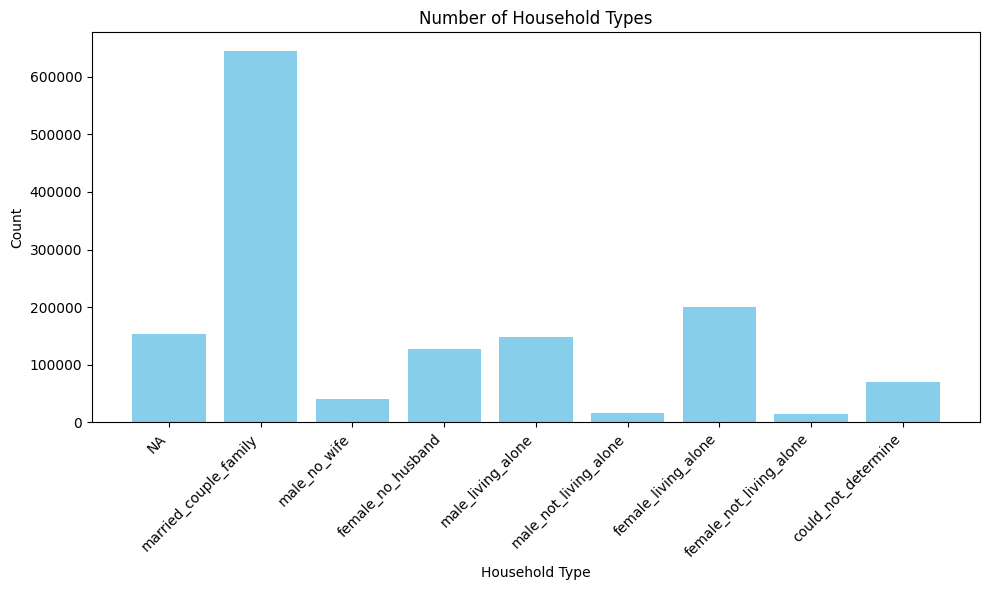

<Figure size 640x480 with 0 Axes>

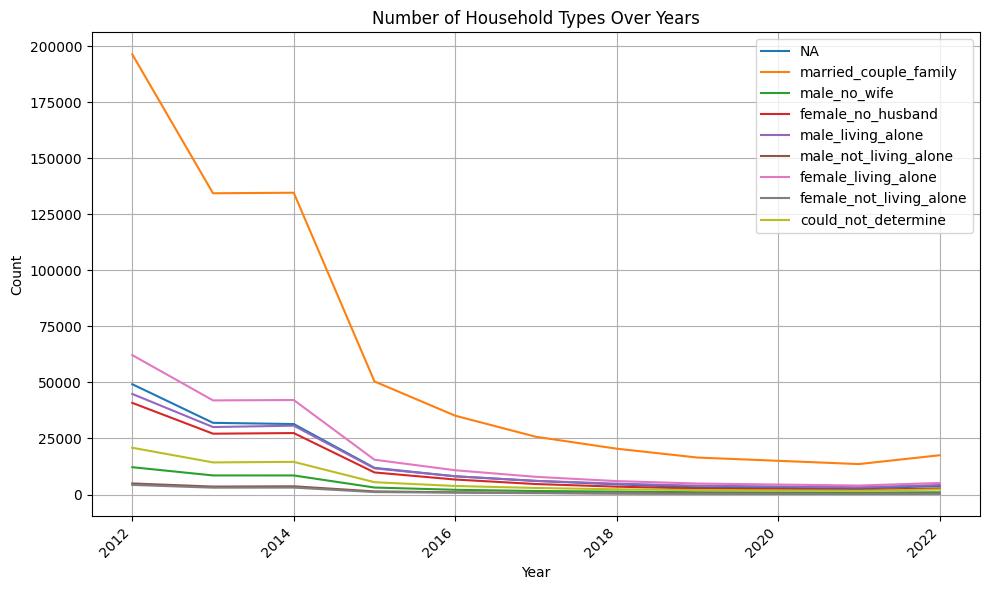

,YEAR,Total Households
0,2012,435981
1,2013,295140
2,2014,296285
3,2015,110506
4,2016,76694
5,2017,56318
6,2018,43982
7,2019,34934
8,2021,28675
9,2022,37511


In [84]:
#Number of Household Types 
temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "NFAMS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

## Count Total 
count = spark.sql("""
    SELECT 
           SUM(CASE WHEN HHTYPE = 0 THEN 1 ELSE 0 END) as NA,
           SUM(CASE WHEN HHTYPE = 1 THEN 1 ELSE 0 END) as married_couple_family,
           SUM(CASE WHEN HHTYPE = 2 THEN 1 ELSE 0 END) as male_no_wife,
           SUM(CASE WHEN HHTYPE = 3 THEN 1 ELSE 0 END) as female_no_husband,
           SUM(CASE WHEN HHTYPE = 4 THEN 1 ELSE 0 END) as male_living_alone,
           SUM(CASE WHEN HHTYPE = 5 THEN 1 ELSE 0 END) as male_not_living_alone,
           SUM(CASE WHEN HHTYPE = 6 THEN 1 ELSE 0 END) as female_living_alone,
           SUM(CASE WHEN HHTYPE = 7 THEN 1 ELSE 0 END) as female_not_living_alone,
           SUM(CASE WHEN HHTYPE = 9 THEN 1 ELSE 0 END) as could_not_determine
    FROM temp
""")

count_pd = count.toPandas()
household_types = ['NA', 'married_couple_family', 'male_no_wife', 'female_no_husband',
                   'male_living_alone', 'male_not_living_alone', 'female_living_alone',
                   'female_not_living_alone', 'could_not_determine']
count_values = [count_pd[col].iloc[0] for col in household_types]

## Count per year 
count_by_year = spark.sql("""
    SELECT 
           YEAR,
           SUM(CASE WHEN HHTYPE = 0 THEN 1 ELSE 0 END) as NA,
           SUM(CASE WHEN HHTYPE = 1 THEN 1 ELSE 0 END) as married_couple_family,
           SUM(CASE WHEN HHTYPE = 2 THEN 1 ELSE 0 END) as male_no_wife,
           SUM(CASE WHEN HHTYPE = 3 THEN 1 ELSE 0 END) as female_no_husband,
           SUM(CASE WHEN HHTYPE = 4 THEN 1 ELSE 0 END) as male_living_alone,
           SUM(CASE WHEN HHTYPE = 5 THEN 1 ELSE 0 END) as male_not_living_alone,
           SUM(CASE WHEN HHTYPE = 6 THEN 1 ELSE 0 END) as female_living_alone,
           SUM(CASE WHEN HHTYPE = 7 THEN 1 ELSE 0 END) as female_not_living_alone,
           SUM(CASE WHEN HHTYPE = 9 THEN 1 ELSE 0 END) as could_not_determine
    FROM household
    GROUP BY YEAR
    ORDER BY YEAR
""")
count_by_year_pd = count_by_year.toPandas()


# Plotting the bar chart of each household type overall 
plt.figure(figsize=(10, 6))
plt.bar(household_types, count_values, color='skyblue')
plt.title('Number of Household Types')
plt.xlabel('Household Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
first_plot = plt.gcf()

# Plotting the line chart for each household type per year 
plt.figure(figsize=(10, 6))
for household_type in household_types:
    plt.plot(count_by_year_pd['YEAR'], count_by_year_pd[household_type], label=household_type)

plt.title('Number of Household Types Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
line_plot = plt.gcf()

#Display Plots 
plt.show()

#Show Number of Household per year
total_households_per_year = count_by_year_pd.drop(columns=['YEAR']).sum(axis=1)
count_by_year_pd['Total Households'] = total_households_per_year
count_by_year_pd[["YEAR", "Total Households"]]

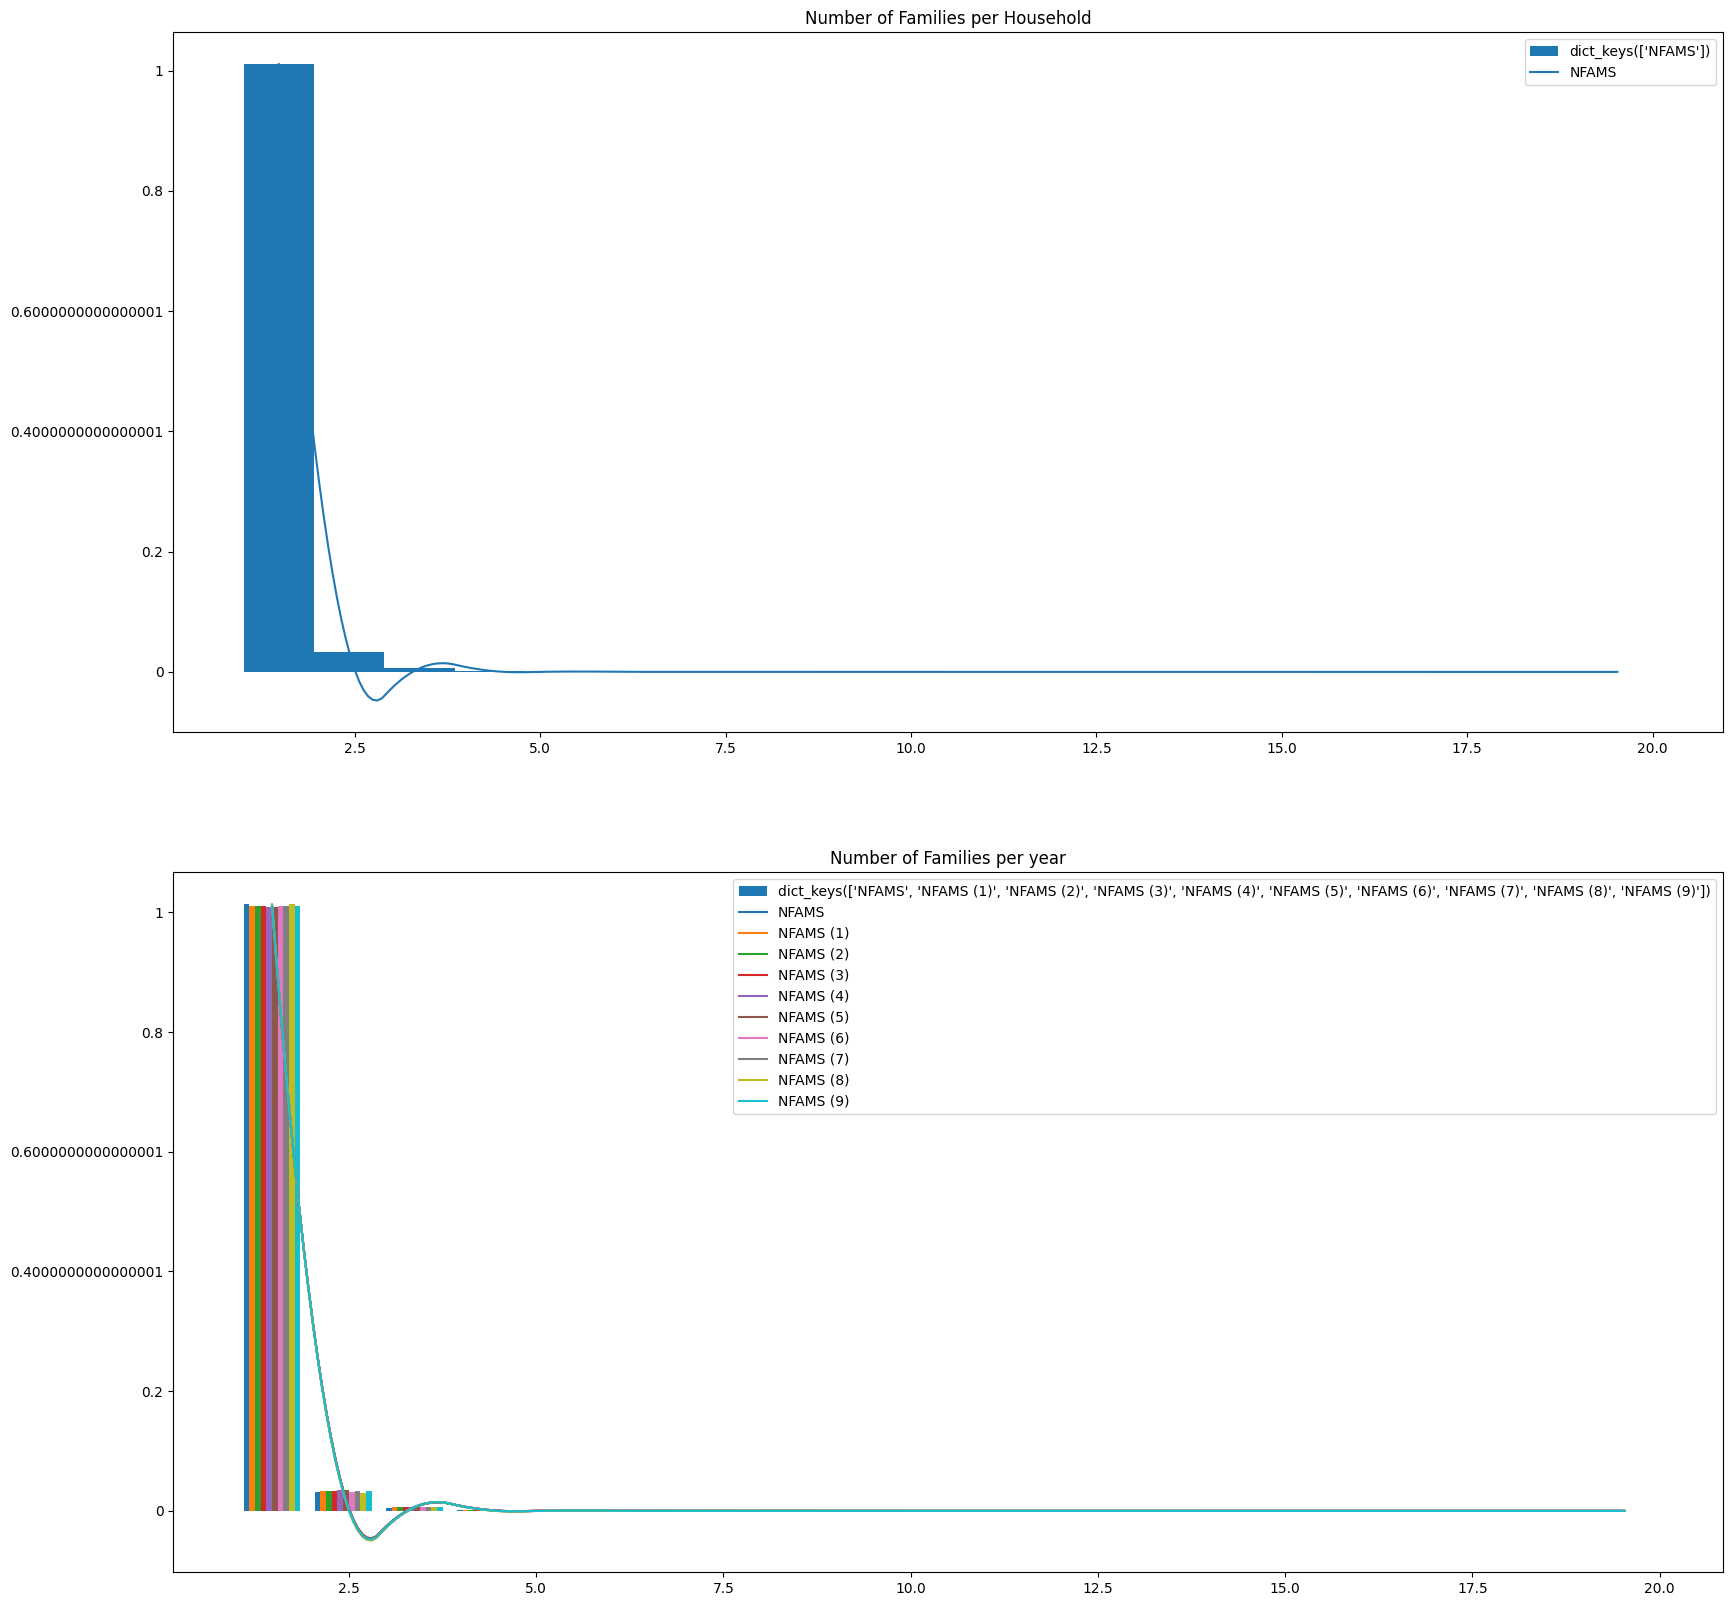

In [19]:
### DELETE BUT GOOD EXAMPLE OF pyspark hist plots work 
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.sql import Row

temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "NFAMS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")

filtered_2012 = temp.filter(F.col('YEAR') == '2012').select(F.col('NFAMS'))
filtered_2013 = temp.filter(F.col('YEAR') == '2013').select(F.col('NFAMS'))
filtered_2014 = temp.filter(F.col('YEAR') == '2014').select(F.col('NFAMS'))
filtered_2015 = temp.filter(F.col('YEAR') == '2015').select(F.col('NFAMS'))
filtered_2016 = temp.filter(F.col('YEAR') == '2016').select(F.col('NFAMS'))
filtered_2017 = temp.filter(F.col('YEAR') == '2017').select(F.col('NFAMS'))
filtered_2018 = temp.filter(F.col('YEAR') == '2018').select(F.col('NFAMS'))
filtered_2019 = temp.filter(F.col('YEAR') == '2019').select(F.col('NFAMS'))
filtered_2021 = temp.filter(F.col('YEAR') == '2021').select(F.col('NFAMS'))
filtered_2022 = temp.filter(F.col('YEAR') == '2022').select(F.col('NFAMS'))

fig, axes = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(20, 20)
distplot(axes[0], [temp.select(F.col('NFAMS'))], bins = 20)
axes[0].set_title('Number of Families per Household')
axes[0].legend()
distplot(axes[1], [filtered_2012, filtered_2013, filtered_2014, filtered_2015, filtered_2016,
                   filtered_2017, filtered_2018, filtered_2019, filtered_2021, filtered_2022], bins=20)
axes[1].set_title('Number of Families per year')
axes[1].legend()


In [36]:
#Look at distribution of families per household 
temp = df_hh.select("SERIAL","YEAR", "HHTYPE", "NFAMS").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
nfams_categories = df_hh.select("NFAMS").distinct().rdd.flatMap(lambda x: x).sortBy(lambda x: x).collect()

sql_query = "SELECT YEAR,"
for nfams_category in nfams_categories:
    sql_query += f" SUM(CASE WHEN NFAMS = {nfams_category} THEN 1 ELSE 0 END) as NFAMS_{nfams_category},"
sql_query = sql_query[:-1]  # Remove the trailing comma
sql_query += " FROM temp GROUP BY YEAR ORDER BY YEAR"


nfams_counts_per_year = spark.sql(sql_query)
print("Distribution of Number of Families per Household per year")
nfams_counts_per_year.show()

+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|YEAR|NFAMS_1|NFAMS_2|NFAMS_3|NFAMS_4|NFAMS_5|NFAMS_6|NFAMS_7|NFAMS_8|NFAMS_9|NFAMS_10|NFAMS_11|NFAMS_12|NFAMS_13|NFAMS_14|NFAMS_15|NFAMS_16|NFAMS_17|NFAMS_18|NFAMS_19|NFAMS_20|
+----+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|2012| 419623|  13119|   2254|    732|    181|     39|     15|      5|      9|       1|       2|       1|       0|       0|       0|       0|       0|       0|       0|       0|
|2013| 283221|   9432|   1757|    534|    125|     39|     12|      7|      3|       3|       1|       1|       0|       0|       0|       1|       0|       0|       0|       4|
|2014| 284236|   9443|   1815|    564|    144|     50|     12|      6|      5|       2|       1|       1|     

In [40]:
from pyspark.sql.functions import sum as spark_sum
total_counts_per_year = temp.groupBy("YEAR").agg(spark_sum("NFAMS").alias("Total_Count"))

# Look at Percent
nfams_counts_per_year_percent = nfams_counts_per_year.join(total_counts_per_year, "YEAR")
for nfams_category in nfams_categories:
    nfams_counts_per_year_percent = nfams_counts_per_year_percent.withColumn(f"NFAMS_{nfams_category}_Percent", 
                                                                             F.round((nfams_counts_per_year_percent[f"NFAMS_{nfams_category}"] / nfams_counts_per_year_percent["Total_Count"]) * 100, 2))
nfams_counts_per_year_percent = nfams_counts_per_year_percent.select("YEAR", *[f"NFAMS_{nfams_category}_Percent" for nfams_category in nfams_categories])
# Show the result
nfams_counts_per_year_percent.show()

+----+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+
|YEAR|NFAMS_1_Percent|NFAMS_2_Percent|NFAMS_3_Percent|NFAMS_4_Percent|NFAMS_5_Percent|NFAMS_6_Percent|NFAMS_7_Percent|NFAMS_8_Percent|NFAMS_9_Percent|NFAMS_10_Percent|NFAMS_11_Percent|NFAMS_12_Percent|NFAMS_13_Percent|NFAMS_14_Percent|NFAMS_15_Percent|NFAMS_16_Percent|NFAMS_17_Percent|NFAMS_18_Percent|NFAMS_19_Percent|NFAMS_20_Percent|
+----+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----

**Look at Number of Families with Group Quarters**

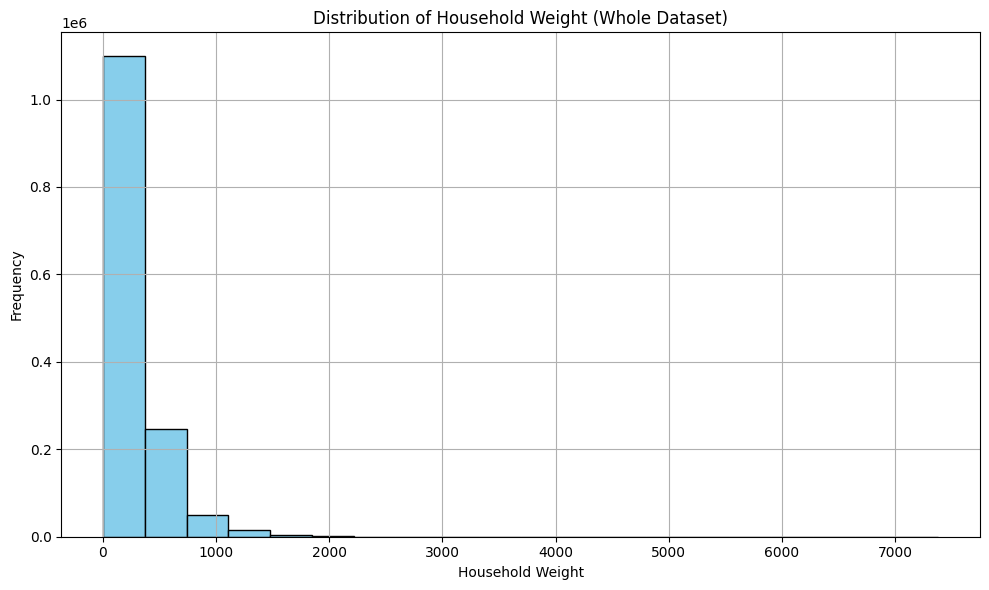

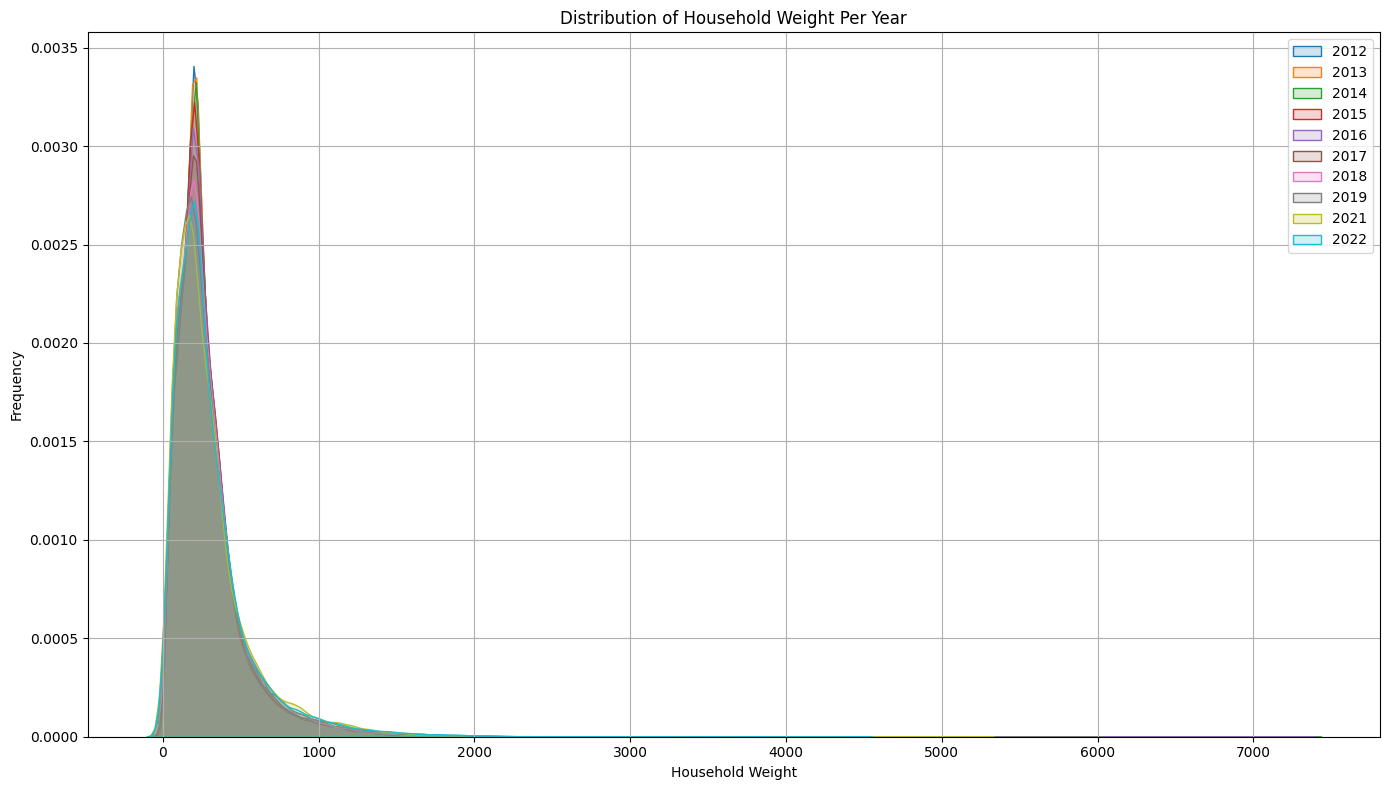

In [33]:
## Look at household weight 
temp = df_hh.select("SERIAL", "YEAR", "HHWT").dropDuplicates(["SERIAL"])
temp.createOrReplaceTempView("temp")
df_pd = temp.toPandas()

# Plot distribution of HHWT over the whole dataset
plt.figure(figsize=(10, 6))
plt.hist(df_pd["HHWT"], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Household Weight (Whole Dataset)')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot distribution of HHWT per year
years = df_pd["YEAR"].unique()
bottom = None
plt.figure(figsize=(14, 8))
for year in years:
    df_year = df_pd[df_pd["YEAR"] == year]
    sns.kdeplot(df_year["HHWT"], label=str(year), fill=True, alpha=0.2)
plt.title('Distribution of Household Weight Per Year')
plt.xlabel('Household Weight')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#Explore Geograpic Variables

In [ ]:
#Explore Values over time 

#### Household Census Variables 

##### Technical Variables 
*   **YEAR**: Census year ranging from 2012 - 2022 exluding 2020. 
*   **SAMPLE**: (IPUMS sample identifier) Sample identifier specific to source of dataset. 
*   **SERIAL**: (Household serial number) Unique identifier for each household in the census across years. 
*   **CBSERIAL**: (Original Census Bureau household serial number) Unique identifier assigned by the creators of the census to uniquely identify each household. 
*   **HHWT**: (Household weight) The household weight indicates how many household in the US this samples represents in a sample of 1000 households. 
*   **HHTYPE**: (Household Type) Household types is a catagorical variable represented by digits 0-8, and 9.
      0. N/A <br>
      1. married-couple family household <br>
      2. Male household, no wife present <br>
      3. Female household, no husband present
      4. Male household, living alone
      5. Male household, not living alone
      6. Female household, living alone
      7. female household, not living alone  
      9. could not be determined
*   **CLUSTER**: (Household cluster for variance estimation) Clusters using Taylor series linear approximation for use with Strava. Will be ignored. 
*   **CPI99**: (CPI-U adjustment factor to 1999 dollars) This is a mutliplier available to convert dollar figures to the dollar amount in 2000 census ensuring dollar figures are comparables between years. 
*   **STRATA**: (Household strata for variance estimation) Correction of complex samples for Cluster variable. 

##### Geographic Variables
*   **STATEICP**: (State (ICPSR code)) State Identifier with digit codes. 
*   **MET2023**: (Metropolitan area (2023 delineations, identifiable areas only)) Numeric identifier of metropolitan areas. 

##### Economic Characteristics 
*   **MOBLHOME**: (Annual mobile home costs)
*   **TAXINCL**: (Mortgage payment includes property taxes) This variable indicated whether mortgage payments include tax (0: N/a, 1: No, 2: Yes)
*   **INSINCL**: (Mortgage payment includes property insurance) This variable indicated whether mortgage payments include insurance (0: N/a, 1: No, 2: Yes)
*   **RENTGRS**: (Monthly gross rent) Monthly gross rent included rental cost including utilities and fuels. This value is not adjusted for inflation and needs to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **CONDOFEE**: (Monthly condominium fee) The condoninium feed reports the monthly fee of the condo including maintenance, administrative and improvement costs. It additionaly may include utilities and fuel. It is not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **MOBLHOME**: (Annual mobile home costs) This cost report the annual amount of cost incurred by owners expluding any loan installments which are reported in MOBLHOME2.

      **How is this displayed?? NEEDS CORRECTION**

*   **HHINCOME**: (Total household income) Total household income reports the total income of all household members over the age of 15 and is not adjusted for inflation. The income of heads of the households is reported in FTOTINC. 

      **How is this displayed?? NEEDS CORRECTION**

*   **FOODSTMP**: (Food stamp recipiency) Food stamps is a catagorical variable indicating whether anyone in the household recieved food stamps. 
      0. N/a
      1. No
      2. Yes
*   **VALUEH**: (House value) House value is reported without adjustment for inflation and is impacted by changes in methods of determining house values. 

      **How is this displayed?? NEEDS CORRECTION**


##### Appliance, Mechanical, Other Variables 
*   **COSTELEC**: (Annual electricity cost) Electricity cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTGAS**: (Annual gas cost) Gas cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTWATR**: (Annual water cost) Water cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **COSTFUEL**: (Annual home heating fuel cost) Heating cost are not adjusted for inflation and need to be corrected. 

      **How is this displayed?? NEEDS CORRECTION**

*   **CINETHH**: (Access to internet) Internet reports if any member of the household has access to the internet. 
      0. N/a
      1. Yes with subscription 
      2. Yes without subscription 
      3. No 
*   **VEHICLES**: (Vehicles available) Vehicles reports the number of cars, vans or trucks are kept at the home by members of the household. 

##### Houshold Composition Variables 
*   **GQ**: (Group quarters status) Group quarties is a catagorical variable to catagorize housing units into households, group quarters or vacant units.The groups are represented by digits 0-6. 
      0. Vacant unit
      1. Household under 1970 definiton
      2. Additional households under 1990 definition
      3. Group quarters
      4. Other group quarters
      5. Additional households under 2000 definition 
      6. Fragment
*   **FARM**: (Farm status) Farm status is a catagorical variable represented by digits. 
      0. n/a
      1. Non-Farm
      2. Farm
      9. Blank/missing
*   **OWNERSHP**: (Ownership of dwelling (tenure) [general version])
      0. n/a
      1. Owned or being bought (loan)
      2. Rented
*   **OWNERSHPD**: (Ownership of dwelling (tenure) [detailed version])
      00. N/a
      10. Owned or being bought
      11. Check mark (owns?)
      12. Owned free and clear
      13. Owned with mortgage or loan
      20. Rented
      21. No cash rent
      22. With cash rent
*   **COUPLETYPE**: (Householder couple type) Couple type reports the relantionship of the householder. 
      0. n/a
      1. Heterosexual married couple 
      2. Homosexual married couple
      3. Heterosexual unmarried couple 
      4. Homosexual unmarried couple  
*   **NFAMS**: (Number of families in household). The number of families within a household is reported numerically. Family is defined as any group who is related by blood, adoption, or marriage. Unrelated individuals are considered a seperate family. 

##### Quality Flags
Quality flags are reported for each variables and described in their own column labeled with a Q before the variable name. Quality flags are reported by a numeric code listed below. 
   0. Not allocated 
   3. Allocated, direct
   4. Allocated
   5. Allocated, indirect
   9. Allocated, direct/indirect
